# Figure S13: Differential site usage by tissue

**Description:** Classification and cleavage deep learning model can accurately predict the location of polyA sites genome-wide and the cleavage probabilities surrounding them. Additionally, the development of a sequence strength models helps discriminate strong and weak sites.

&rarr; Run this notebook with the `tf-train` kernel


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
## specify working directories

PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_S13")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [5]:
with open(os.path.join(RESDIR, 'dapa_clusters.filtered.vs_pooled.with_sequence.with_predictions.processed.pickle'), mode = 'rb') as handle:
    dapa_data = pickle.load(handle)
    
print("Input data shape :", dapa_data.shape)
print("\nNumber of sites  :", dapa_data[['gene','relative_position']].drop_duplicates().shape[0])
print("Number of tissues:", dapa_data['tissue_desc'].nunique())
print("Number of genes  :", dapa_data['gene'].nunique())


Input data shape : (60672, 41)

Number of sites  : 12148
Number of tissues: 5
Number of genes  : 6074


#### Distribution of changes in usage relative to the mean

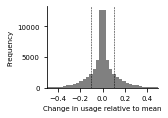

In [6]:
fig,ax = plt.subplots(1,1, figsize = (2,1.5))

ax.hist(dapa_data['deltaRelUsage_mean'], bins = 50, color = 'gray')

ax.axvline(-0.10, color = 'black', linestyle = 'dashed', linewidth = 0.5)
ax.axvline(+0.10, color = 'black', linestyle = 'dashed', linewidth = 0.5)

ax.set_xlabel("Change in usage relative to mean")
ax.set_xlim(-0.5,0.5)

ax.set_ylabel("Frequency")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


#### Selecting significantly differentially-used sites

In [7]:
qval_cutoff = 0.05

cond1 = (dapa_data['usage_interest'] >= 0.05)
cond2 = (dapa_data['qval_minlog'] >= -1 * np.log10(qval_cutoff))
cond3 = (dapa_data['relative_position'] == 'proximal')

sig_prox = dapa_data.loc[cond1 & cond2 & cond3].copy()

print("Baseline usage >= 5%   :", cond1.sum())
print("Adjusted p-value < 0.05:", cond2.sum())
print("Proximal sites         :", cond3.sum())


Baseline usage >= 5%   : 49057
Adjusted p-value < 0.05: 36970
Proximal sites         : 30336


In [8]:
condDELTA = np.abs(sig_prox['deltaRelUsage_mean']) >= 0.1

sig_prox_labs = sig_prox.loc[condDELTA, 'gene'].unique().tolist()
print(len(sig_prox_labs))

print(sig_prox.loc[condDELTA].shape)
print(sig_prox.loc[condDELTA, ['chrom','repr_site','strand']].drop_duplicates().shape)
print(sig_prox.loc[condDELTA, 'tissue_desc'].value_counts())


3297
(7554, 41)
(3297, 3)
NSC: Neuronal stem cells           1809
JEG3: Placental choriocarcinoma    1708
Cerebellum tissue                  1674
ESC: Embryonic stem cells          1373
HTR8: Placental trophoblasts        990
Name: tissue_desc, dtype: int64


In [9]:
plot_labels = sig_prox.loc[condDELTA, 'label'].unique()

plot_data = (dapa_data.loc[dapa_data['label'].isin(plot_labels)]
             .pivot(index='label', columns='tissue_desc', values='deltaRelUsage_mean')
             .replace([np.inf, -np.inf], np.nan))

print(plot_data.shape)

plot_data.fillna(0).to_csv(os.path.join(OUTDIR, 'dapa.site_data.proximal.txt'), sep = "\t")


(3297, 5)


#### Identifying tissue-specific differentially-used polyA sites

In [10]:
tissues_brain    = ["Cerebellum tissue", "NSC: Neuronal stem cells"]
tissues_placenta = ["ESC: Embryonic stem cells", "HTR8: Placental trophoblasts", "JEG3: Placental choriocarcinoma"]

proximal_cluster_members = {
    'placenta-specific' : ["chr10:100232411:-", "chr10:103600291:-", "chr10:104027583:+", "chr10:121743109:-", "chr10:124759856:-", "chr10:124987431:+", "chr10:124988330:-", "chr10:13136920:+", "chr10:13278037:-", "chr10:15778852:-", "chr10:26747077:-", "chr10:27111732:-", "chr10:276939:-", "chr10:30014453:-", "chr10:42831401:+", "chr10:45792963:+", "chr10:58287828:+", "chr10:68482702:-", "chr10:68694471:+", "chr10:70139211:-", "chr10:71816548:-", "chr10:72334505:-", "chr10:73134532:-", "chr10:73242180:+", "chr10:73242830:-", "chr10:73250740:-", "chr10:73674298:-", "chr10:74121766:-", "chr10:74708538:+", "chr10:75231276:+", "chr10:84514805:+", "chr10:87753116:-", "chr10:91280980:+", "chr10:99705691:+", "chr11:1010919:+", "chr11:108474183:-", "chr11:110462564:+", "chr11:112062628:+", "chr11:112085146:-", "chr11:116845410:-", "chr11:118523875:+", "chr11:121089606:+", "chr11:122811163:+", "chr11:124632435:+", "chr11:12528265:+", "chr11:130876984:-", "chr11:13731494:+", "chr11:1556385:-", "chr11:20118879:+", "chr11:30336806:+", "chr11:31783771:+", "chr11:32602466:+", "chr11:32978044:+", "chr11:45811570:+", "chr11:45910175:-", "chr11:57816736:+", "chr11:62593268:-", "chr11:62667070:+", "chr11:62790245:+", "chr11:63574775:-", "chr11:63759046:+", "chr11:64789136:-", "chr11:6483057:+", "chr11:65719683:-", "chr11:68940600:+", "chr11:72293301:-", "chr11:73400798:-", "chr11:75265726:-", "chr11:76142650:+", "chr11:77322974:-", "chr11:77664939:-", "chr11:86345662:+", "chr11:93761708:+", "chr11:9446228:+", "chr11:94963346:-", "chr11:95069120:+", "chr12:104119322:-", "chr12:104758097:+", "chr12:104994717:+", "chr12:109086221:+", "chr12:109544885:+", "chr12:110350974:+", "chr12:110452899:-", "chr12:110491925:-", "chr12:11172272:+", "chr12:115961254:-", "chr12:116852942:+", "chr12:117143779:-", "chr12:120461586:+", "chr12:120696690:+", "chr12:121777782:+", "chr12:122231547:-", "chr12:123294527:-", "chr12:123472202:-", "chr12:12466138:+", "chr12:12829980:+", "chr12:132139002:-", "chr12:132584292:+", "chr12:132921457:-", "chr12:133059600:+", "chr12:14776646:+", "chr12:21470147:-", "chr12:21516201:+", "chr12:22685709:+", "chr12:26339318:-", "chr12:26966010:+", "chr12:26973637:-", "chr12:27420814:+", "chr12:27798186:+", "chr12:31385705:-", "chr12:32743614:+", "chr12:42087064:-", "chr12:42447027:+", "chr12:43788086:+", "chr12:47663290:-", "chr12:48653426:-", "chr12:49019236:-", "chr12:51246578:+", "chr12:51509189:+", "chr12:53040330:+", "chr12:53413039:+", "chr12:55992737:+", "chr12:56113148:+", "chr12:56162976:-", "chr12:56310431:-", "chr12:64448681:+", "chr12:66137835:-", "chr12:67313180:+", "chr12:68844193:+", "chr12:69269938:+", "chr12:69424208:+", "chr12:69815723:+", "chr12:71677356:+", "chr12:71702044:+", "chr12:74541451:+", "chr12:75499550:-", "chr12:76047596:-", "chr12:79773825:-", "chr12:88049015:-", "chr12:95866133:+", "chr12:9696374:+", "chr13:110149064:-", "chr13:19674755:-", "chr13:24883038:-", "chr13:27256569:+", "chr13:29765251:-", "chr13:32777808:+", "chr13:33105244:-", "chr13:38360840:+", "chr13:39050105:+", "chr13:40809828:+", "chr13:44941015:-", "chr13:45033607:+", "chr13:49310657:-", "chr13:49491845:+", "chr13:49660727:-", "chr13:50013169:+", "chr13:50970458:+", "chr13:52475163:+", "chr13:52687853:+", "chr13:75285115:-", "chr13:77001332:+", "chr13:79314576:-", "chr13:79552921:+", "chr13:95791100:+", "chr13:97391479:+", "chr13:98448437:+", "chr14:100278468:+", "chr14:103557100:-", "chr14:105395205:+", "chr14:21496981:+", "chr14:22834346:+", "chr14:24316944:+", "chr14:24812494:-", "chr14:31093430:+", "chr14:34516010:-", "chr14:39182110:+", "chr14:45116045:-", "chr14:49622698:+", "chr14:49783813:-", "chr14:50721496:-", "chr14:52004694:+", "chr14:52641887:-", "chr14:54789126:+", "chr14:55048454:+", "chr14:55066213:+", "chr14:57410607:+", "chr14:58548118:+", "chr14:63373890:-", "chr14:63598441:-", "chr14:64932316:+", "chr14:65743140:+", "chr14:67338071:-", "chr14:67651150:-", "chr14:67677221:-", "chr14:68874321:-", "chr14:69771669:+", "chr14:73120128:+", "chr14:73220401:+", "chr14:73716694:-", "chr14:74060442:-", "chr14:75134244:-", "chr14:76211689:+", "chr14:77276990:-", "chr14:88467771:-", "chr14:88611887:+", "chr14:89161635:-", "chr14:89797125:-", "chr14:90866848:-", "chr14:92064093:-", "chr14:92162705:+", "chr14:93227110:+", "chr14:95532912:-", "chr14:96565048:+", "chr15:100569238:-", "chr15:101175919:-", "chr15:22825462:+", "chr15:28111424:-", "chr15:29268383:-", "chr15:34141898:-", "chr15:34856627:-", "chr15:38485083:+", "chr15:40394141:+", "chr15:40574459:+", "chr15:41579328:+", "chr15:41768626:+", "chr15:42945176:-", "chr15:43352188:+", "chr15:43407214:-", "chr15:50560294:-", "chr15:51911935:+", "chr15:52313112:-", "chr15:58595445:-", "chr15:58858995:+", "chr15:62841485:+", "chr15:63305913:+", "chr15:65002995:-", "chr15:65150452:-", "chr15:65444928:-", "chr15:65576498:+", "chr15:65887922:+", "chr15:66336836:-", "chr15:68779872:-", "chr15:69272000:+", "chr15:70049800:-", "chr15:72586554:+", "chr15:74844853:-", "chr15:75658630:+", "chr15:77995536:-", "chr15:78498450:+", "chr15:82471941:-", "chr15:82544271:-", "chr15:84802484:+", "chr15:90272207:+", "chr16:11676732:+", "chr16:11837353:-", "chr16:11872680:-", "chr16:14668889:+", "chr16:1840200:+", "chr16:19079261:+", "chr16:1986113:+", "chr16:22286630:+", "chr16:23581014:-", "chr16:28964669:+", "chr16:30352846:-", "chr16:30399402:+", "chr16:30744278:+", "chr16:31709795:+", "chr16:31914670:+", "chr16:371861:-", "chr16:47155376:-", "chr16:47699740:+", "chr16:48542511:-", "chr16:5085043:+", "chr16:53491040:+", "chr16:54113402:+", "chr16:56844764:+", "chr16:57471683:+", "chr16:57665025:+", "chr16:58520697:-", "chr16:67175192:+", "chr16:67176473:-", "chr16:67871315:+", "chr16:68299009:+", "chr16:69084211:+", "chr16:69326912:-", "chr16:70250230:-", "chr16:70252385:-", "chr16:77198802:+", "chr16:83811665:+", "chr16:85088575:+", "chr16:854485:-", "chr16:85673586:+", "chr17:1495607:-", "chr17:17846824:-", "chr17:18931211:+", "chr17:2324131:+", "chr17:2681907:+", "chr17:28399034:-", "chr17:28701732:+", "chr17:28905427:-", "chr17:3033937:+", "chr17:30466418:+", "chr17:31533048:+", "chr17:31999233:+", "chr17:35132069:-", "chr17:37613111:-", "chr17:38850084:-", "chr17:40356795:+", "chr17:40835084:+", "chr17:4166160:-", "chr17:41690998:+", "chr17:42200469:-", "chr17:42571824:+", "chr17:43768301:-", "chr17:44078294:-", "chr17:442578:-", "chr17:45105973:+", "chr17:46755988:+", "chr17:47120434:-", "chr17:4733602:+", "chr17:47683637:+", "chr17:49404835:-", "chr17:49580355:+", "chr17:49701326:-", "chr17:5474289:-", "chr17:57121246:+", "chr17:62448935:+", "chr17:64499620:-", "chr17:65010714:-", "chr17:6643116:+", "chr17:67340775:-", "chr17:67692923:+", "chr17:67983152:+", "chr17:68046630:+", "chr17:7235285:-", "chr17:7457612:+", "chr17:75135987:-", "chr17:7578623:+", "chr17:75879739:-", "chr17:75942877:-", "chr17:76082383:-", "chr17:78855542:-", "chr17:7912203:+", "chr17:80200673:-", "chr17:80436620:+", "chr17:8160675:-", "chr18:10550358:+", "chr18:24135595:+", "chr18:3278174:+", "chr18:35335225:-", "chr18:36174648:+", "chr18:46263302:+", "chr18:47156029:-", "chr18:48862646:+", "chr18:49043802:-", "chr18:49482065:-", "chr18:50947839:+", "chr18:56602822:-", "chr18:58396702:+", "chr18:63331475:-", "chr18:672826:-", "chr18:70327117:+", "chr18:79903702:-", "chr18:9954825:+", "chr19:10111293:+", "chr19:11834069:+", "chr19:12875373:-", "chr19:14169099:+", "chr19:1435145:+", "chr19:16101496:+", "chr19:18442893:-", "chr19:18777951:+", "chr19:19680030:+", "chr19:19893712:+", "chr19:19933314:+", "chr19:20005665:-", "chr19:2273239:+", "chr19:3053160:-", "chr19:32383254:+", "chr19:32484893:+", "chr19:34228093:+", "chr19:35623609:+", "chr19:36335751:-", "chr19:37243921:+", "chr19:3750879:-", "chr19:39397773:+", "chr19:44108324:+", "chr19:45409616:-", "chr19:45783780:-", "chr19:46609303:+", "chr19:47004558:+", "chr19:47271951:+", "chr19:4795557:+", "chr19:52702813:-", "chr19:52838624:-", "chr19:53875335:+", "chr19:57621924:+", "chr19:58315203:+", "chr19:5917320:-", "chr19:7114691:-", "chr19:8262418:+", "chr19:972290:+", "chr1:100150495:+", "chr1:10461226:-", "chr1:108933542:+", "chr1:109094796:+", "chr1:111713113:+", "chr1:112700735:+", "chr1:113124720:+", "chr1:113912468:+", "chr1:114774142:-", "chr1:12510361:+", "chr1:1254900:-", "chr1:1292869:-", "chr1:145744432:-", "chr1:145925722:-", "chr1:149941261:-", "chr1:150474358:+", "chr1:150575961:-", "chr1:151052659:-", "chr1:153645470:+", "chr1:153661421:+", "chr1:15492278:-", "chr1:156596814:+", "chr1:15662280:+", "chr1:160278479:-", "chr1:16250654:-", "chr1:162525088:+", "chr1:167426428:+", "chr1:168200206:+", "chr1:169132017:+", "chr1:169396043:+", "chr1:171796941:+", "chr1:173886636:+", "chr1:1752518:-", "chr1:178474051:+", "chr1:179076566:+", "chr1:180269668:-", "chr1:180886341:+", "chr1:183143011:+", "chr1:183927331:+", "chr1:185101057:+", "chr1:185118988:-", "chr1:186313828:-", "chr1:19218959:-", "chr1:19258986:+", "chr1:200859761:+", "chr1:201969935:+", "chr1:202331738:-", "chr1:202728695:-", "chr1:202880824:-", "chr1:203023253:+", "chr1:203488519:+", "chr1:204556092:+", "chr1:207359712:+", "chr1:211941348:-", "chr1:212815324:+", "chr1:21679230:-", "chr1:220151094:-", "chr1:222735185:+", "chr1:224385390:-", "chr1:226992722:-", "chr1:228099123:+", "chr1:229304006:+", "chr1:231332752:-", "chr1:235131648:-", "chr1:2403220:+", "chr1:241497785:-", "chr1:244843283:+", "chr1:244854413:-", "chr1:24537014:+", "chr1:247300319:-", "chr1:25223109:-", "chr1:25361141:+", "chr1:25498731:+", "chr1:26855716:+", "chr1:27761603:+", "chr1:29147883:-", "chr1:30872614:-", "chr1:32933863:-", "chr1:33009919:-", "chr1:35603137:-", "chr1:35929609:+", "chr1:37814814:-", "chr1:3814787:-", "chr1:40240681:+", "chr1:40771106:+", "chr1:42775524:+", "chr1:43164317:-", "chr1:45510146:+", "chr1:45618244:+", "chr1:46220240:+", "chr1:46676568:-", "chr1:50441274:-", "chr1:51355236:-", "chr1:51915564:-", "chr1:52086984:+", "chr1:52346633:+", "chr1:52352543:-", "chr1:52417020:+", "chr1:52423400:-", "chr1:53245544:-", "chr1:54031664:-", "chr1:54112360:+", "chr1:62864378:+", "chr1:65636324:+", "chr1:6635114:-", "chr1:67704724:-", "chr1:77092032:-", "chr1:77695989:-", "chr1:85266247:-", "chr1:85652807:-", "chr1:86348736:-", "chr1:86862720:-", "chr1:87345579:+", "chr1:88981964:-", "chr1:9267894:+", "chr1:93138236:+", "chr1:93154350:-", "chr1:96814790:+", "chr20:13714324:-", "chr20:1443537:-", "chr20:17942213:-", "chr20:18486855:-", "chr20:20035344:-", "chr20:20389882:-", "chr20:23375192:-", "chr20:33645520:+", "chr20:34234841:-", "chr20:35650140:-", "chr20:36048239:-", "chr20:36230334:+", "chr20:36527094:+", "chr20:36653209:-", "chr20:3933573:-", "chr20:41182113:-", "chr20:41402545:-", "chr20:44306601:-", "chr20:46686643:-", "chr20:50879041:+", "chr20:50934944:-", "chr20:50961083:+", "chr20:5546641:-", "chr20:58360664:+", "chr20:58445550:+", "chr20:6038036:+", "chr20:62294884:+", "chr20:62309157:-", "chr20:62800068:+", "chr20:62945630:+", "chr20:63958379:-", "chr20:64275650:+", "chr20:647869:-", "chr21:14372797:-", "chr21:32631132:-", "chr21:36751191:-", "chr21:39175458:-", "chr21:41988642:-", "chr21:42909099:+", "chr21:8433702:+", "chr22:19441498:-", "chr22:19850239:-", "chr22:20127181:+", "chr22:24572133:+", "chr22:26525772:-", "chr22:36226623:-", "chr22:38683903:+", "chr22:40770418:-", "chr22:40932200:+", "chr22:41674799:-", "chr22:41826298:+", "chr22:42086113:-", "chr22:42512555:-", "chr22:42585647:-", "chr22:45340756:+", "chr22:50444390:+", "chr22:50523471:+", "chr22:50625027:-", "chr2:101019491:+", "chr2:101891495:+", "chr2:102715841:-", "chr2:102843837:+", "chr2:111166976:+", "chr2:119977454:+", "chr2:127304345:-", "chr2:127846664:-", "chr2:130346623:+", "chr2:138572293:+", "chr2:151802588:-", "chr2:160274002:-", "chr2:161411416:+", "chr2:165874008:-", "chr2:169529753:-", "chr2:172506192:+", "chr2:174348364:-", "chr2:174428214:+", "chr2:175074278:-", "chr2:177222170:+", "chr2:177542053:+", "chr2:178395617:+", "chr2:179109129:-", "chr2:189670830:+", "chr2:190965154:+", "chr2:197475119:+", "chr2:199932890:-", "chr2:200910170:-", "chr2:200981015:-", "chr2:201168241:+", "chr2:201623801:-", "chr2:202037498:+", "chr2:202880605:-", "chr2:203305610:+", "chr2:203427597:+", "chr2:206123817:-", "chr2:207754479:+", "chr2:216205423:+", "chr2:219075972:-", "chr2:223757170:-", "chr2:224473908:-", "chr2:227357179:+", "chr2:227555121:+", "chr2:232344349:+", "chr2:234494586:-", "chr2:236125247:+", "chr2:241672628:+", "chr2:24769158:+", "chr2:25232975:-", "chr2:25737486:-", "chr2:26135107:+", "chr2:26781145:+", "chr2:277505:+", "chr2:30159550:+", "chr2:36551033:+", "chr2:37096374:+", "chr2:38564033:-", "chr2:43888277:-", "chr2:44320825:-", "chr2:46905236:-", "chr2:47074142:+", "chr2:48515127:+", "chr2:53864868:-", "chr2:55236620:-", "chr2:55636106:-", "chr2:60798467:+", "chr2:61048923:+", "chr2:61141595:-", "chr2:61164662:+", "chr2:61478706:-", "chr2:65269901:+", "chr2:70279289:+", "chr2:71078639:+", "chr2:71188306:-", "chr2:73074591:-", "chr2:85053770:+", "chr2:86774202:+", "chr2:8858120:-", "chr2:9488586:-", "chr2:95087206:-", "chr2:96274735:-", "chr2:98618404:+", "chr3:100365277:-", "chr3:101822825:+", "chr3:11557978:-", "chr3:119821955:-", "chr3:122359590:-", "chr3:123272176:+", "chr3:12583709:+", "chr3:127035579:+", "chr3:12897873:-", "chr3:129169576:-", "chr3:132677188:+", "chr3:133600651:-", "chr3:136145653:+", "chr3:139357591:-", "chr3:14112575:-", "chr3:141926199:+", "chr3:141944525:-", "chr3:15042410:-", "chr3:154275667:-", "chr3:156543005:-", "chr3:158692131:+", "chr3:16260388:-", "chr3:169786769:+", "chr3:170095220:-", "chr3:170866320:-", "chr3:172398770:+", "chr3:179020041:-", "chr3:179588787:-", "chr3:179624499:+", "chr3:180617823:+", "chr3:183680939:+", "chr3:184172729:+", "chr3:194403465:-", "chr3:196554188:-", "chr3:196931674:+", "chr3:28323536:-", "chr3:32526754:-", "chr3:42225124:+", "chr3:42785156:-", "chr3:48444028:+", "chr3:48984169:+", "chr3:49533677:+", "chr3:49721498:-", "chr3:5216122:+", "chr3:56621758:+", "chr3:58170774:+", "chr3:58428034:-", "chr3:69055044:-", "chr3:73067190:+", "chr3:78597238:-", "chr4:10075153:-", "chr4:105682628:-", "chr4:106046090:-", "chr4:106348491:+", "chr4:108630021:+", "chr4:112187151:+", "chr4:119298489:-", "chr4:119499973:+", "chr4:120059435:-", "chr4:127920319:-", "chr4:138171849:-", "chr4:1692799:-", "chr4:173331700:-", "chr4:176328349:+", "chr4:177431562:-", "chr4:1814289:-", "chr4:183640612:-", "chr4:2250227:-", "chr4:25929349:+", "chr4:27023960:+", "chr4:39477582:+", "chr4:39547296:-", "chr4:39778628:+", "chr4:41954460:+", "chr4:4417736:+", "chr4:4419474:-", "chr4:444240:-", "chr4:48422526:+", "chr4:51915138:+", "chr4:52023936:-", "chr4:52720283:+", "chr4:53459616:+", "chr4:56459661:+", "chr4:7060527:-", "chr4:70690177:+", "chr4:76114867:-", "chr4:78912968:+", "chr4:98880375:-", "chr4:99062808:+", "chr5:103550855:-", "chr5:10657815:+", "chr5:109187666:+", "chr5:110762782:+", "chr5:111498846:-", "chr5:111730817:-", "chr5:112844976:+", "chr5:112878645:-", "chr5:113594111:+", "chr5:115613795:-", "chr5:122829755:+", "chr5:126544870:-", "chr5:126624952:+", "chr5:131201719:+", "chr5:131393110:+", "chr5:133104471:+", "chr5:136179494:+", "chr5:137752616:-", "chr5:138507441:-", "chr5:139626850:+", "chr5:140672344:+", "chr5:141988038:+", "chr5:144159273:-", "chr5:154057370:+", "chr5:154456145:+", "chr5:154966968:+", "chr5:16666026:-", "chr5:168556950:-", "chr5:176345985:+", "chr5:177295756:+", "chr5:177306660:+", "chr5:178148565:+", "chr5:179920286:-", "chr5:32229641:-", "chr5:32355423:-", "chr5:32601128:+", "chr5:34830783:+", "chr5:34925680:+", "chr5:36875683:-", "chr5:37065231:+", "chr5:38477938:-", "chr5:40826331:-", "chr5:43527112:-", "chr5:50842335:+", "chr5:52802047:+", "chr5:64724270:-", "chr5:65590178:-", "chr5:69229290:+", "chr5:72364413:+", "chr5:74781367:-", "chr5:81313135:+", "chr5:83056658:-", "chr5:9037684:-", "chr5:90516780:-", "chr5:91369626:-", "chr5:98855203:-", "chr6:106666360:+", "chr6:10709735:+", "chr6:108042825:-", "chr6:108522464:+", "chr6:109163163:+", "chr6:111025590:+", "chr6:11135815:+", "chr6:116244216:+", "chr6:117561681:-", "chr6:117708585:+", "chr6:118907798:+", "chr6:127289778:-", "chr6:135285294:-", "chr6:13612165:+", "chr6:13621618:-", "chr6:139372974:-", "chr6:142219602:+", "chr6:143489366:+", "chr6:144852916:+", "chr6:145798194:-", "chr6:149590919:+", "chr6:152989997:-", "chr6:157292493:-", "chr6:158099005:+", "chr6:167040315:+", "chr6:170577361:-", "chr6:18129707:-", "chr6:25983751:+", "chr6:26171346:+", "chr6:26524422:+", "chr6:2833029:-", "chr6:28366746:+", "chr6:30070329:+", "chr6:30700297:-", "chr6:31268838:-", "chr6:3152658:+", "chr6:32903464:+", "chr6:33290932:+", "chr6:33697567:-", "chr6:33771397:-", "chr6:39105193:-", "chr6:41099967:+", "chr6:41599959:+", "chr6:41794816:-", "chr6:42080901:+", "chr6:42228125:-", "chr6:43029596:+", "chr6:43054232:-", "chr6:43523846:-", "chr6:49431284:-", "chr6:52686277:+", "chr6:56458881:-", "chr6:70588781:+", "chr6:71305579:+", "chr6:81746294:-", "chr6:84124909:-", "chr6:85611088:-", "chr6:87341756:+", "chr6:89631495:+", "chr6:96555273:+", "chr6:96891013:-", "chr7:100107142:+", "chr7:102425447:+", "chr7:102456820:-", "chr7:102473166:+", "chr7:103098679:+", "chr7:103312520:-", "chr7:103368154:+", "chr7:105604772:-", "chr7:106250423:-", "chr7:107919964:+", "chr7:117230019:+", "chr7:120975656:+", "chr7:122076244:-", "chr7:129832793:-", "chr7:135185766:-", "chr7:135674447:+", "chr7:139423172:+", "chr7:148801024:+", "chr7:155309214:+", "chr7:155642764:-", "chr7:155777824:+", "chr7:157268580:+", "chr7:158733611:-", "chr7:19696731:-", "chr7:2255004:-", "chr7:25123673:-", "chr7:26190305:-", "chr7:26212438:+", "chr7:32584166:+", "chr7:32869003:-", "chr7:44578309:-", "chr7:4767640:+", "chr7:50592579:-", "chr7:5622654:-", "chr7:6023832:-", "chr7:74231663:-", "chr7:75027120:-", "chr7:87325348:-", "chr7:88206289:-", "chr7:92200014:-", "chr7:968892:-", "chr7:98206201:+", "chr7:99366261:+", "chr8:116772207:+", "chr8:141194247:+", "chr8:1782693:+", "chr8:18027755:+", "chr8:26371129:+", "chr8:29064885:+", "chr8:29336540:-", "chr8:30570757:+", "chr8:33498940:+", "chr8:38990803:-", "chr8:41510355:+", "chr8:42837193:-", "chr8:43201823:+", "chr8:469054:+", "chr8:48061570:+", "chr8:56217465:+", "chr8:58582273:+", "chr8:66680227:+", "chr8:6759663:+", "chr8:80036589:-", "chr8:86467763:+", "chr8:90051999:+", "chr8:98158409:+", "chr9:104759580:+", "chr9:111361887:-", "chr9:112218605:-", "chr9:112470604:+", "chr9:113165518:-", "chr9:113264491:+", "chr9:113388210:-", "chr9:122323082:+", "chr9:122918047:-", "chr9:124952786:-", "chr9:125363339:+", "chr9:127219467:+", "chr9:127407667:+", "chr9:127691056:+", "chr9:127940880:-", "chr9:128309115:-", "chr9:128361222:+", "chr9:128437344:+", "chr9:132690809:+", "chr9:133331011:-", "chr9:134158298:+", "chr9:134844545:+", "chr9:135810425:-", "chr9:136207486:-", "chr9:136724657:-", "chr9:137835737:+", "chr9:15467389:+", "chr9:32540771:-", "chr9:32553762:-", "chr9:33044980:-", "chr9:37778681:+", "chr9:69073097:+", "chr9:71861014:-", "chr9:77417365:+", "chr9:7798345:-", "chr9:85546540:-", "chr9:86265930:-", "chr9:91213963:-", "chr9:92297483:-", "chr9:95100486:-", "chr9:96386115:-", "chr9:97673620:+", "chr9:98124461:-", "chr9:99982480:-", "chrX:100840916:+", "chrX:102752440:+", "chrX:103253586:-", "chrX:103378071:+", "chrX:104191444:+", "chrX:11121878:+", "chrX:119471316:+", "chrX:129804937:-", "chrX:13714303:-", "chrX:13769222:+", "chrX:150987931:+", "chrX:154023196:-", "chrX:155942992:+", "chrX:16760433:+", "chrX:19535409:-", "chrX:20127235:-", "chrX:23703677:-", "chrX:24077969:+", "chrX:2741228:+", "chrX:31121814:-", "chrX:38806443:+", "chrX:56566945:+", "chrX:71300268:+", "chrX:71574351:+", "chrX:77905384:+", "chrX:80675819:-", "chrX:81114067:-"],
    'placenta-weak'     : ["chr10:100274699:-", "chr10:102150179:+", "chr10:103388235:+", "chr10:103445716:+", "chr10:103882536:-", "chr10:110604632:+", "chr10:113908693:+", "chr10:119831199:-", "chr10:12167573:-", "chr10:124835943:+", "chr10:130180376:+", "chr10:13318974:-", "chr10:23120969:+", "chr10:253530:+", "chr10:32268568:-", "chr10:35569739:+", "chr10:60794233:+", "chr10:69171704:+", "chr10:70423925:+", "chr10:73375780:-", "chr10:74118389:+", "chr10:77792102:-", "chr10:80155596:-", "chr10:92654347:+", "chr10:95663876:-", "chr11:102232742:+", "chr11:102398654:-", "chr11:10852796:-", "chr11:111726050:+", "chr11:18407390:+", "chr11:32853827:+", "chr11:35620864:+", "chr11:59575516:-", "chr11:60890730:-", "chr11:62714750:-", "chr11:65126036:+", "chr11:6681931:-", "chr11:72097365:-", "chr11:727048:+", "chr11:83261761:-", "chr11:95834099:-", "chr12:102074188:-", "chr12:103988211:+", "chr12:108569092:+", "chr12:109556696:-", "chr12:109917085:+", "chr12:11891625:+", "chr12:120127274:-", "chr12:121916643:+", "chr12:122505057:-", "chr12:122770821:+", "chr12:122979449:+", "chr12:122984432:-", "chr12:132624041:-", "chr12:132721315:+", "chr12:25209442:-", "chr12:280888:-", "chr12:56589605:+", "chr12:56598367:-", "chr12:57603246:+", "chr12:6870936:-", "chr12:71786598:+", "chr13:106490198:-", "chr13:106543326:-", "chr13:113640817:+", "chr13:20728930:-", "chr13:21147601:+", "chr13:23337326:-", "chr13:30460894:-", "chr13:37009316:+", "chr13:39011146:-", "chr13:48261384:+", "chr13:49701479:-", "chr13:52413152:-", "chr14:103535083:+", "chr14:103912515:-", "chr14:35317467:+", "chr14:54477179:-", "chr14:58272002:+", "chr14:70372799:-", "chr14:70729659:-", "chr14:71111970:+", "chr14:74736711:+", "chr14:74836189:+", "chr14:93241911:-", "chr14:95090323:-", "chr15:43796003:+", "chr15:52066143:+", "chr15:60347395:-", "chr15:65661778:-", "chr15:72140962:+", "chr15:78897228:+", "chr15:82990114:+", "chr15:85749155:+", "chr16:1677820:+", "chr16:18804982:-", "chr16:19858971:-", "chr16:2213683:-", "chr16:23466161:-", "chr16:23570858:+", "chr16:30424037:-", "chr16:46956386:-", "chr16:57153735:-", "chr16:57449:+", "chr16:69342673:+", "chr16:70572297:+", "chr16:70662736:-", "chr16:72024504:+", "chr16:72784531:-", "chr16:84667578:+", "chr16:8854912:-", "chr16:89563076:+", "chr16:89669516:+", "chr17:15717440:+", "chr17:18107359:+", "chr17:20999750:-", "chr17:27879229:-", "chr17:44206592:-", "chr17:50382673:-", "chr17:59697307:-", "chr17:60445467:-", "chr17:6653178:+", "chr17:67744132:+", "chr17:744622:-", "chr17:75706756:+", "chr17:81558608:-", "chr17:82488255:+", "chr17:82657066:-", "chr17:83094844:+", "chr18:21529281:-", "chr18:319423:-", "chr18:59328935:-", "chr18:9546916:-", "chr19:10643911:+", "chr19:10930253:+", "chr19:11062065:+", "chr19:11322069:-", "chr19:15159632:-", "chr19:18866617:+", "chr19:21192177:+", "chr19:39425514:+", "chr19:40215574:+", "chr19:42227052:+", "chr19:43607456:-", "chr19:49625859:+", "chr19:6413349:-", "chr19:812220:+", "chr19:867962:-", "chr1:100193912:-", "chr1:10180608:+", "chr1:108932296:-", "chr1:113697208:-", "chr1:114717293:-", "chr1:115693693:+", "chr1:117960055:+", "chr1:150308347:+", "chr1:150513554:+", "chr1:160030223:-", "chr1:160997694:-", "chr1:165908108:+", "chr1:168075454:+", "chr1:169921329:-", "chr1:1786755:-", "chr1:185297764:-", "chr1:18908290:-", "chr1:197155120:-", "chr1:201876368:+", "chr1:20652186:-", "chr1:227732302:-", "chr1:2310115:+", "chr1:235112024:-", "chr1:24472975:+", "chr1:24840949:+", "chr1:27824303:+", "chr1:28603353:-", "chr1:37803587:-", "chr1:42926237:-", "chr1:45511226:-", "chr1:46042691:-", "chr1:46635045:-", "chr1:52687470:-", "chr1:61681045:-", "chr1:6186617:-", "chr1:62163502:+", "chr1:6525568:-", "chr1:81991814:+", "chr1:85251967:-", "chr1:93360969:+", "chr1:9367864:+", "chr1:9729984:-", "chr20:13817226:+", "chr20:18561016:+", "chr20:32195616:-", "chr20:36752043:-", "chr20:37518829:-", "chr20:3923624:+", "chr20:43461690:+", "chr20:44496220:-", "chr20:4855100:-", "chr20:5190455:+", "chr21:33359820:+", "chr21:36376630:+", "chr21:38823796:+", "chr21:43758946:+", "chr22:17592464:-", "chr22:19133937:-", "chr22:20065925:+", "chr22:30926611:-", "chr22:31434185:+", "chr22:31619362:-", "chr22:37656042:+", "chr22:40826130:-", "chr2:109616645:+", "chr2:112117394:+", "chr2:118110025:+", "chr2:127941567:-", "chr2:143946677:-", "chr2:170083740:+", "chr2:170966584:+", "chr2:177616252:-", "chr2:181930518:+", "chr2:190969332:-", "chr2:197550909:+", "chr2:200478529:+", "chr2:201379464:-", "chr2:208357209:+", "chr2:222941821:+", "chr2:229767212:-", "chr2:238446730:+", "chr2:240466363:+", "chr2:241106295:-", "chr2:241352550:+", "chr2:26190871:-", "chr2:27650844:+", "chr2:32011884:-", "chr2:38294887:-", "chr2:38744892:-", "chr2:39736305:-", "chr2:64632708:-", "chr2:65022845:+", "chr2:70297271:-", "chr2:74532998:+", "chr2:9584266:-", "chr3:101592912:+", "chr3:108047078:-", "chr3:113001373:+", "chr3:113004919:-", "chr3:113444885:-", "chr3:119431820:-", "chr3:120324602:-", "chr3:121664109:-", "chr3:125231271:-", "chr3:128913013:+", "chr3:138296517:+", "chr3:146069618:-", "chr3:149965055:-", "chr3:150742065:-", "chr3:156705130:+", "chr3:160500179:-", "chr3:171061496:-", "chr3:185631095:+", "chr3:195514501:-", "chr3:196936853:-", "chr3:197614026:-", "chr3:197784017:+", "chr3:42646086:+", "chr3:47586021:-", "chr3:48270987:+", "chr3:49108129:-", "chr3:49277632:-", "chr3:52545486:-", "chr3:9476327:+", "chr4:105369566:-", "chr4:129112653:+", "chr4:139289951:-", "chr4:152979615:+", "chr4:169720985:+", "chr4:185400313:-", "chr4:2231198:-", "chr4:25418489:+", "chr4:3512566:-", "chr4:37861942:+", "chr4:47450870:-", "chr4:539528:+", "chr4:55434825:-", "chr4:56033104:+", "chr4:6881211:+", "chr4:98442664:+", "chr5:123344973:-", "chr5:128187022:+", "chr5:141640981:-", "chr5:154418997:+", "chr5:163453576:-", "chr5:177610273:+", "chr5:178885021:+", "chr5:33988874:-", "chr5:36193713:-", "chr5:39373203:-", "chr5:40759919:-", "chr5:43445328:-", "chr5:55424931:-", "chr5:58970070:-", "chr5:62388625:-", "chr5:69364869:-", "chr5:73580517:+", "chr5:79322125:+", "chr5:95464260:-", "chr5:97162933:-", "chr6:10983411:-", "chr6:111661289:-", "chr6:143495486:-", "chr6:158192418:+", "chr6:158507239:+", "chr6:158766555:-", "chr6:163573795:+", "chr6:17610039:+", "chr6:24701712:+", "chr6:30545963:-", "chr6:30591311:+", "chr6:36924555:+", "chr6:41933044:+", "chr6:486101:-", "chr6:87513938:-", "chr6:89084520:+", "chr6:90514877:-", "chr7:100367732:+", "chr7:106091697:-", "chr7:123542057:-", "chr7:129427212:+", "chr7:129486407:+", "chr7:141653899:+", "chr7:142667354:+", "chr7:143269109:+", "chr7:149226172:+", "chr7:21514741:+", "chr7:2537879:-", "chr7:27526123:-", "chr7:32487035:-", "chr7:38230408:+", "chr7:39706307:+", "chr7:43625184:+", "chr7:44072251:-", "chr7:44212549:+", "chr7:44383590:-", "chr7:45100099:-", "chr7:55431527:+", "chr7:55955259:+", "chr7:6656430:+", "chr7:91872891:-", "chr7:92611539:-", "chr7:99532681:+", "chr8:102253903:-", "chr8:102648847:-", "chr8:102828002:-", "chr8:116644831:-", "chr8:130053818:-", "chr8:132013205:+", "chr8:139730344:-", "chr8:144511293:-", "chr8:15764484:+", "chr8:30786162:-", "chr8:37843885:-", "chr8:38411620:-", "chr8:39105000:+", "chr8:42552978:+", "chr8:53967122:-", "chr8:61501228:-", "chr8:81701721:-", "chr8:93732773:-", "chr8:96239416:-", "chr8:99875665:+", "chr9:116425610:-", "chr9:121179707:-", "chr9:124877414:+", "chr9:131121221:+", "chr9:131498136:+", "chr9:134437264:+", "chr9:137582187:-", "chr9:137615359:+", "chr9:19055726:-", "chr9:21862945:+", "chr9:26905341:-", "chr9:32450732:+", "chr9:35854427:+", "chr9:37089732:+", "chr9:69254787:+", "chr9:78271874:+", "chr9:93679499:+", "chr9:96490504:+", "chr9:96641250:-", "chrX:103587515:+", "chrX:123912236:+", "chrX:130056667:+", "chrX:134889115:-", "chrX:1386274:-", "chrX:1403140:-", "chrX:152971461:+", "chrX:15826071:-", "chrX:24214507:+", "chrX:2882285:+", "chrX:47247983:+", "chrX:49074639:-", "chrX:50092482:+", "chrX:70286596:-", "chrX:71059247:-"],
    'brain-mixed'       : ["chr10:100549998:+", "chr10:1017686:+", "chr10:101785761:-", "chr10:102864206:+", "chr10:103088155:-", "chr10:104267453:+", "chr10:118309917:-", "chr10:119035045:-", "chr10:119168050:-", "chr10:119677439:+", "chr10:122931508:-", "chr10:125853521:+", "chr10:131968104:-", "chr10:132375456:+", "chr10:133420482:+", "chr10:22331067:+", "chr10:28051173:-", "chr10:28620534:+", "chr10:30312828:-", "chr10:49458658:-", "chr10:5763738:+", "chr10:58369595:+", "chr10:58396136:+", "chr10:73007748:-", "chr10:75177728:+", "chr10:86437010:-", "chr10:86935837:-", "chr10:87051480:-", "chr10:91907754:-", "chr10:92353870:+", "chr10:96520986:-", "chr11:108158627:-", "chr11:112233753:+", "chr11:114408911:+", "chr11:118409195:+", "chr11:118602927:+", "chr11:123070121:-", "chr11:124694636:+", "chr11:125097037:-", "chr11:27366104:-", "chr11:34100507:+", "chr11:36231985:+", "chr11:36489468:-", "chr11:45933678:-", "chr11:612057:+", "chr11:61897300:-", "chr11:62625063:-", "chr11:62738635:+", "chr11:65592644:+", "chr11:65777619:-", "chr11:65998424:-", "chr11:66665454:-", "chr11:68053814:-", "chr11:68261462:-", "chr11:69088430:+", "chr11:71434958:-", "chr11:73872767:-", "chr11:78436264:-", "chr11:8947508:-", "chr11:90201448:-", "chr11:93478835:-", "chr11:93730280:-", "chr11:94876210:+", "chr11:9751820:+", "chr12:100341510:+", "chr12:10606268:-", "chr12:106972656:+", "chr12:108522687:-", "chr12:112160322:-", "chr12:118033343:-", "chr12:120095741:-", "chr12:12118383:-", "chr12:123408660:+", "chr12:123660722:+", "chr12:123758270:+", "chr12:12475895:-", "chr12:13083447:+", "chr12:132078908:+", "chr12:133121007:-", "chr12:27029749:+", "chr12:29338258:-", "chr12:43721701:-", "chr12:4489417:-", "chr12:48043561:-", "chr12:48930258:-", "chr12:49763001:+", "chr12:51094837:-", "chr12:53190794:+", "chr12:53479613:+", "chr12:54350875:+", "chr12:56238217:-", "chr12:56731580:-", "chr12:66123640:-", "chr12:6666738:-", "chr12:68767516:+", "chr12:70354645:+", "chr12:71924311:+", "chr12:76352008:-", "chr12:93402275:+", "chr13:100531785:-", "chr13:102678459:+", "chr13:21177355:+", "chr13:29509787:-", "chr13:32432785:-", "chr13:41083068:+", "chr13:41216973:-", "chr13:45337176:-", "chr13:47942710:-", "chr13:48052754:+", "chr13:52033345:+", "chr13:72759042:-", "chr13:99562810:+", "chr14:22771697:+", "chr14:22900768:-", "chr14:23356662:-", "chr14:24189232:-", "chr14:24438402:+", "chr14:31446993:-", "chr14:34712012:-", "chr14:39136838:+", "chr14:49894765:+", "chr14:50325895:+", "chr14:52727991:+", "chr14:53046025:-", "chr14:58408745:-", "chr14:59504705:+", "chr14:67589538:-", "chr14:69242356:+", "chr14:70583588:-", "chr14:75014924:-", "chr14:75954822:+", "chr14:90043339:+", "chr14:91458138:-", "chr14:91969515:-", "chr15:22866881:+", "chr15:25337248:-", "chr15:43407093:+", "chr15:43804577:-", "chr15:44562086:+", "chr15:45421337:+", "chr15:55205349:-", "chr15:57716250:+", "chr15:67191511:+", "chr15:68295682:+", "chr15:74802900:+", "chr15:78169605:+", "chr15:79898903:-", "chr15:82834658:+", "chr15:89834304:-", "chr15:89900873:-", "chr16:12664592:-", "chr16:13952193:+", "chr16:14436036:-", "chr16:19700684:+", "chr16:21655935:+", "chr16:23067407:-", "chr16:23523038:-", "chr16:24825456:+", "chr16:29871508:-", "chr16:3581183:-", "chr16:412370:+", "chr16:46929433:+", "chr16:50319090:-", "chr16:53491689:-", "chr16:56432624:-", "chr16:69463807:+", "chr16:84479639:-", "chr16:8892774:-", "chr16:89871084:+", "chr17:16031407:-", "chr17:18065283:+", "chr17:18209529:+", "chr17:18328524:-", "chr17:19677411:+", "chr17:29561292:-", "chr17:30899436:-", "chr17:32379073:+", "chr17:34963045:+", "chr17:35573995:+", "chr17:36539301:+", "chr17:37478764:+", "chr17:37515474:-", "chr17:38767297:-", "chr17:39728575:+", "chr17:42024774:+", "chr17:43211469:+", "chr17:44011782:-", "chr17:45150950:+", "chr17:50752548:+", "chr17:5432695:+", "chr17:5441911:-", "chr17:59950302:+", "chr17:7312273:+", "chr17:75778249:-", "chr17:76270705:+", "chr17:76563581:+", "chr17:82392223:-", "chr17:8474293:-", "chr18:11884045:-", "chr18:20949926:-", "chr18:24451593:+", "chr18:26454974:-", "chr18:2803607:+", "chr18:3458347:+", "chr18:35308923:+", "chr18:67514917:-", "chr18:68674731:-", "chr18:80139540:+", "chr18:80159006:-", "chr18:8406854:+", "chr19:10923039:-", "chr19:11165581:-", "chr19:12813526:+", "chr19:1376950:+", "chr19:14149533:-", "chr19:15422097:-", "chr19:16133540:+", "chr19:17212642:+", "chr19:19506978:+", "chr19:29207388:-", "chr19:29615694:+", "chr19:35739250:-", "chr19:36511028:-", "chr19:38383474:+", "chr19:41324201:+", "chr19:44476292:-", "chr19:45409783:+", "chr19:4653303:+", "chr19:47210190:+", "chr19:48630404:+", "chr19:48630688:-", "chr19:49491840:+", "chr19:50047172:+", "chr19:51098517:-", "chr19:52861054:-", "chr19:53136175:-", "chr19:53354555:+", "chr19:57446510:+", "chr19:57905773:-", "chr19:58259448:-", "chr19:58346856:-", "chr19:6212465:-", "chr19:8308764:-", "chr19:9652615:-", "chr1:100023450:+", "chr1:100990062:-", "chr1:112460229:+", "chr1:114395926:-", "chr1:1440765:+", "chr1:151292130:-", "chr1:151874055:-", "chr1:154270993:+", "chr1:154582290:-", "chr1:155900100:-", "chr1:161363193:+", "chr1:161959061:+", "chr1:173786685:+", "chr1:173799550:-", "chr1:174995210:+", "chr1:175010263:+", "chr1:179919707:+", "chr1:183626274:-", "chr1:184620325:+", "chr1:19334374:+", "chr1:202892100:-", "chr1:204127664:+", "chr1:20743209:-", "chr1:20807293:-", "chr1:209852077:+", "chr1:218331449:+", "chr1:2184963:-", "chr1:223003024:+", "chr1:226360803:-", "chr1:229441739:-", "chr1:229659575:+", "chr1:231565723:+", "chr1:234605763:-", "chr1:235167295:-", "chr1:236900667:+", "chr1:2404821:-", "chr1:241593602:-", "chr1:244408847:-", "chr1:248848968:+", "chr1:26469224:+", "chr1:27851527:+", "chr1:28577759:+", "chr1:31906820:-", "chr1:32856183:+", "chr1:34988164:-", "chr1:35420179:+", "chr1:36137030:-", "chr1:36329176:+", "chr1:37536540:-", "chr1:3775955:+", "chr1:38864501:-", "chr1:39486816:+", "chr1:39624154:-", "chr1:43967752:+", "chr1:44651722:+", "chr1:44654502:-", "chr1:44850839:-", "chr1:53214472:-", "chr1:70262098:-", "chr1:86743586:+", "chr1:868126:-", "chr1:88835803:+", "chr1:90028222:+", "chr1:91525702:+", "chr20:17607999:+", "chr20:17614098:-", "chr20:17990686:+", "chr20:18188034:+", "chr20:23354702:+", "chr20:3038358:+", "chr20:3190519:-", "chr20:32333630:+", "chr20:44491559:+", "chr20:46062048:-", "chr20:47209348:-", "chr20:49890394:+", "chr20:50584553:+", "chr20:50890349:-", "chr20:62841198:-", "chr21:32314037:-", "chr21:33577345:+", "chr21:33577904:-", "chr21:33897884:+", "chr21:34516669:-", "chr21:36034943:-", "chr21:36416826:+", "chr21:37202744:+", "chr21:43030190:+", "chr21:46664940:+", "chr22:25461222:+", "chr22:25725959:+", "chr22:26491929:-", "chr22:27853229:-", "chr22:35743601:-", "chr22:41359386:+", "chr22:41433575:-", "chr22:42059764:-", "chr22:42571832:-", "chr22:45185624:+", "chr22:45196039:-", "chr22:50446805:-", "chr2:10054835:+", "chr2:100576701:+", "chr2:135840443:-", "chr2:147930821:+", "chr2:148787566:+", "chr2:17784717:+", "chr2:178431543:-", "chr2:182777374:+", "chr2:189033779:-", "chr2:20249854:-", "chr2:202775974:-", "chr2:20449345:+", "chr2:210021228:+", "chr2:219183490:+", "chr2:232581426:+", "chr2:237779878:+", "chr2:239048690:-", "chr2:36846174:-", "chr2:38781962:+", "chr2:38984696:-", "chr2:39601506:+", "chr2:42330742:+", "chr2:46624462:+", "chr2:63893057:-", "chr2:64459005:+", "chr2:68175213:+", "chr2:69325273:-", "chr2:70281507:-", "chr2:73729889:-", "chr2:74153538:-", "chr2:74215067:+", "chr2:86503503:-", "chr2:86603698:-", "chr2:95182967:+", "chr2:95415549:+", "chr2:96273334:+", "chr3:111194167:+", "chr3:119494565:+", "chr3:129431528:-", "chr3:131016373:+", "chr3:136949125:+", "chr3:141448623:+", "chr3:14671205:+", "chr3:150542177:-", "chr3:160258181:-", "chr3:160433908:+", "chr3:179334612:+", "chr3:179392496:+", "chr3:182938432:-", "chr3:183812623:+", "chr3:184242423:-", "chr3:185917327:-", "chr3:189956831:-", "chr3:191398426:+", "chr3:196468902:-", "chr3:3150817:-", "chr3:31637486:+", "chr3:32996732:-", "chr3:36987866:-", "chr3:49270877:-", "chr3:49359495:-", "chr3:5180744:+", "chr3:52710785:-", "chr3:53192540:+", "chr3:53885271:-", "chr3:56622080:-", "chr3:57572074:-", "chr3:72374722:-", "chr3:75422863:-", "chr3:87254916:+", "chr3:8879875:-", "chr4:102251552:-", "chr4:102887671:+", "chr4:108034490:+", "chr4:109713917:-", "chr4:121816908:+", "chr4:128036319:+", "chr4:13568846:-", "chr4:139047643:+", "chr4:139389320:+", "chr4:143470131:+", "chr4:143553413:+", "chr4:145129159:+", "chr4:147635650:-", "chr4:174236970:-", "chr4:17841655:-", "chr4:182890259:-", "chr4:184695002:-", "chr4:185363964:+", "chr4:1979795:+", "chr4:25123610:-", "chr4:25279085:+", "chr4:3240657:+", "chr4:39824316:-", "chr4:52594422:-", "chr4:7030717:+", "chr4:70808513:+", "chr4:73075686:-", "chr4:75814211:+", "chr4:82925719:-", "chr4:83264303:-", "chr4:84669793:-", "chr4:87140807:+", "chr4:87458345:+", "chr4:88726476:-", "chr4:94668220:+", "chr5:10265011:+", "chr5:10437038:+", "chr5:115522744:-", "chr5:119249120:+", "chr5:119542252:+", "chr5:126493911:+", "chr5:132644601:+", "chr5:138469225:+", "chr5:138555827:-", "chr5:140706415:+", "chr5:143228687:+", "chr5:1461700:-", "chr5:149496066:-", "chr5:151181233:-", "chr5:157757165:+", "chr5:159285651:+", "chr5:171410738:+", "chr5:172210215:-", "chr5:177442056:+", "chr5:178210761:+", "chr5:179837252:+", "chr5:1798460:-", "chr5:183736:+", "chr5:62388740:+", "chr5:65665922:+", "chr5:6668633:+", "chr5:69177696:+", "chr5:69554568:+", "chr5:72910329:+", "chr5:76735473:+", "chr5:80478901:+", "chr5:95813977:-", "chr5:95887389:-", "chr6:105277768:-", "chr6:111278743:+", "chr6:112070771:-", "chr6:113940767:-", "chr6:127288357:+", "chr6:13786742:-", "chr6:15521633:+", "chr6:157209257:+", "chr6:160106549:+", "chr6:18224593:-", "chr6:28378961:-", "chr6:31353961:-", "chr6:32185792:-", "chr6:3269462:-", "chr6:34877512:+", "chr6:42744854:-", "chr6:52502965:-", "chr6:57184860:+", "chr6:69675857:-", "chr6:75715681:+", "chr6:87674925:-", "chr6:98869675:-", "chr6:99432438:-", "chr7:100064027:-", "chr7:100565993:+", "chr7:107620473:+", "chr7:108562515:-", "chr7:12688986:+", "chr7:127346721:-", "chr7:129756014:+", "chr7:131487962:+", "chr7:134679709:+", "chr7:139189800:+", "chr7:149003441:-", "chr7:149431501:-", "chr7:23175302:+", "chr7:23505002:-", "chr7:34930538:-", "chr7:44708548:+", "chr7:56000110:+", "chr7:66811189:+", "chr7:73736403:-", "chr7:77779655:+", "chr7:80218036:+", "chr7:87834675:-", "chr7:99547125:-", "chr8:100153612:+", "chr8:102204623:-", "chr8:103069282:+", "chr8:103398961:-", "chr8:11327735:+", "chr8:123014147:-", "chr8:13083918:-", "chr8:132847587:+", "chr8:140531772:-", "chr8:144522016:+", "chr8:22251166:+", "chr8:22619921:+", "chr8:23432352:-", "chr8:27285750:-", "chr8:52623583:-", "chr8:55825444:+", "chr8:60866896:+", "chr8:65603291:-", "chr8:67196259:+", "chr8:73981862:+", "chr8:89926399:+", "chr8:96230930:-", "chr9:120389198:-", "chr9:127445371:+", "chr9:128500959:+", "chr9:128695530:+", "chr9:129827581:-", "chr9:130138016:+", "chr9:130704573:+", "chr9:133362864:-", "chr9:134030459:+", "chr9:134032880:-", "chr9:136359600:+", "chr9:19373542:+", "chr9:33917986:+", "chr9:34252439:+", "chr9:38397954:+", "chr9:75146845:+", "chr9:77716274:-", "chr9:79725497:+", "chr9:86026961:+", "chr9:87731392:+", "chr9:98015816:+", "chr9:99969485:+", "chrX:104102447:-", "chrX:106940737:-", "chrX:108084337:-", "chrX:108154177:+", "chrX:120626051:-", "chrX:12977160:+", "chrX:130413340:+", "chrX:13709662:+", "chrX:154483982:-", "chrX:18892970:-", "chrX:2487536:-", "chrX:40651277:-", "chrX:48605117:+", "chrX:55181646:-", "chrX:72580629:-", "chrX:74585477:-"],
    'placenta-mixed'    : ["chr10:101553485:+", "chr10:102162663:+", "chr10:102480800:-", "chr10:102676663:-", "chr10:103077964:+", "chr10:103303240:-", "chr10:110293896:-", "chr10:11460899:-", "chr10:119137607:+", "chr10:119573466:-", "chr10:121957145:-", "chr10:122254210:+", "chr10:122992446:-", "chr10:123055136:+", "chr10:124397453:-", "chr10:133391693:+", "chr10:13645890:-", "chr10:16592912:-", "chr10:25025517:+", "chr10:27538512:+", "chr10:28682704:+", "chr10:31806292:-", "chr10:34111115:-", "chr10:48435877:+", "chr10:49818388:-", "chr10:6115751:+", "chr10:63167443:-", "chr10:63620969:+", "chr10:68791476:+", "chr10:70152435:-", "chr10:72096520:-", "chr10:72233298:+", "chr10:73783371:+", "chr10:8015052:+", "chr10:80432991:+", "chr10:84152544:+", "chr10:87965526:+", "chr10:89419923:+", "chr10:89582987:-", "chr10:90905647:+", "chr10:91865275:+", "chr10:92030997:+", "chr11:103062084:-", "chr11:10508898:-", "chr11:106007983:-", "chr11:107502726:-", "chr11:108107497:+", "chr11:110170597:+", "chr11:111875341:-", "chr11:118897808:-", "chr11:11956569:+", "chr11:121308029:+", "chr11:123724779:-", "chr11:125621057:+", "chr11:1276623:-", "chr11:128967143:-", "chr11:129863779:-", "chr11:134265850:+", "chr11:14457551:-", "chr11:16755346:+", "chr11:17088866:-", "chr11:216137:-", "chr11:2634173:-", "chr11:27494898:-", "chr11:33073547:+", "chr11:33355365:+", "chr11:3358385:-", "chr11:33709434:-", "chr11:3675870:-", "chr11:44244930:+", "chr11:46673034:+", "chr11:47778231:-", "chr11:48168323:+", "chr11:57528633:-", "chr11:57700362:+", "chr11:58620959:+", "chr11:59637717:-", "chr11:61802274:-", "chr11:62750963:-", "chr11:63827714:+", "chr11:63997701:+", "chr11:65305981:+", "chr11:65538817:-", "chr11:6610841:-", "chr11:67603508:-", "chr11:74977057:+", "chr11:76349957:-", "chr11:76551544:+", "chr11:85957686:-", "chr11:87322967:+", "chr11:8919550:+", "chr11:9139502:-", "chr11:93147684:-", "chr11:93812398:+", "chr11:94180980:+", "chr11:94546602:+", "chr11:95130029:+", "chr11:95831729:+", "chr11:96353225:-", "chr12:101395330:-", "chr12:103951252:-", "chr12:105371252:+", "chr12:106510104:+", "chr12:108646570:-", "chr12:111644088:-", "chr12:112027783:-", "chr12:113192153:+", "chr12:116717335:-", "chr12:118414550:+", "chr12:120491021:-", "chr12:121002421:-", "chr12:122143819:+", "chr12:123257931:+", "chr12:12329469:-", "chr12:123472168:+", "chr12:12644023:+", "chr12:130876279:+", "chr12:14498247:+", "chr12:14786475:-", "chr12:19519394:+", "chr12:27322720:+", "chr12:27694924:+", "chr12:3283671:+", "chr12:42158220:-", "chr12:46188228:-", "chr12:46359385:-", "chr12:47077347:-", "chr12:47968486:+", "chr12:48768397:-", "chr12:50082726:+", "chr12:50476456:+", "chr12:51189180:-", "chr12:54241622:-", "chr12:55752580:-", "chr12:55757127:+", "chr12:56663597:-", "chr12:57234725:+", "chr12:57516647:+", "chr12:57768636:-", "chr12:57822805:-", "chr12:62404642:+", "chr12:62593272:+", "chr12:6570343:-", "chr12:68742511:+", "chr12:69579181:+", "chr12:79589790:-", "chr12:88199028:+", "chr12:93409356:-", "chr12:93501788:+", "chr12:95021893:-", "chr12:95300915:+", "chr13:100086229:-", "chr13:110720770:+", "chr13:110878621:-", "chr13:112886821:+", "chr13:113264542:+", "chr13:20783701:-", "chr13:20974021:-", "chr13:27666250:+", "chr13:37009495:-", "chr13:45956447:-", "chr13:78615142:-", "chr13:94629682:+", "chr13:98022480:+", "chr13:98793552:-", "chr14:101927519:+", "chr14:102506844:-", "chr14:103503281:+", "chr14:20357844:+", "chr14:21210936:-", "chr14:22881374:+", "chr14:23098488:+", "chr14:23275472:-", "chr14:24298781:+", "chr14:32157462:+", "chr14:34434171:-", "chr14:35029368:+", "chr14:45203585:-", "chr14:49625177:-", "chr14:50632672:+", "chr14:50633640:-", "chr14:54426934:-", "chr14:54941174:-", "chr14:57204577:-", "chr14:57289516:+", "chr14:59472861:-", "chr14:60134688:+", "chr14:60293352:+", "chr14:60711905:-", "chr14:67333962:+", "chr14:69051863:-", "chr14:70326275:-", "chr14:71739346:+", "chr14:72970882:-", "chr14:73696074:+", "chr14:73884629:+", "chr14:77512017:-", "chr14:90405607:+", "chr14:96881359:+", "chr14:99398529:-", "chr14:99511313:+", "chr15:101271265:-", "chr15:22983100:-", "chr15:29701536:-", "chr15:30942001:+", "chr15:40036040:-", "chr15:40472819:+", "chr15:41899441:-", "chr15:42158866:-", "chr15:44525619:+", "chr15:45609635:+", "chr15:48342419:+", "chr15:49127351:-", "chr15:50707576:-", "chr15:55355642:-", "chr15:56428807:-", "chr15:59096430:+", "chr15:59662863:-", "chr15:60423000:-", "chr15:61852676:-", "chr15:63264081:+", "chr15:63591445:+", "chr15:66781831:+", "chr15:67201671:-", "chr15:67526540:+", "chr15:68193802:-", "chr15:71825432:-", "chr15:72343886:-", "chr15:74632508:-", "chr15:74920276:-", "chr15:75900294:+", "chr15:75933128:+", "chr15:77046710:-", "chr15:83017491:-", "chr15:89195750:+", "chr15:90921194:+", "chr15:99386295:+", "chr15:99715699:-", "chr16:1325347:+", "chr16:1445339:-", "chr16:15867268:-", "chr16:19061964:+", "chr16:2176937:+", "chr16:22334020:+", "chr16:2949811:+", "chr16:29697637:+", "chr16:29820113:+", "chr16:29992994:-", "chr16:3006634:+", "chr16:30834040:-", "chr16:31759885:+", "chr16:3301400:+", "chr16:3371975:-", "chr16:4456701:+", "chr16:46581244:-", "chr16:47050:-", "chr16:48361052:-", "chr16:522484:+", "chr16:57428551:-", "chr16:57758732:-", "chr16:58519103:+", "chr16:66613744:+", "chr16:66887208:+", "chr16:66944124:+", "chr16:68300615:-", "chr16:69305286:+", "chr16:69698897:+", "chr16:70333822:+", "chr16:70373253:+", "chr16:70381470:-", "chr16:71282367:-", "chr16:71857134:+", "chr16:74451957:-", "chr16:75172087:+", "chr16:75447130:-", "chr16:77213002:+", "chr16:81045174:+", "chr16:81082324:-", "chr16:82148271:-", "chr16:84178379:-", "chr16:85779403:-", "chr16:85813:-", "chr16:87329336:-", "chr16:87404686:+", "chr16:88861111:+", "chr16:89234144:+", "chr16:89738506:-", "chr16:90043471:+", "chr16:9117530:+", "chr17:1001632:+", "chr17:10680336:-", "chr17:1420829:-", "chr17:1520212:-", "chr17:1574402:-", "chr17:15977729:-", "chr17:17185556:+", "chr17:17246835:-", "chr17:18244839:-", "chr17:18274229:-", "chr17:2323581:-", "chr17:2385216:-", "chr17:2690364:-", "chr17:28361468:+", "chr17:29548034:+", "chr17:30526813:+", "chr17:30634322:+", "chr17:31375828:+", "chr17:32330868:-", "chr17:32482376:+", "chr17:35004804:+", "chr17:35011679:-", "chr17:35100423:-", "chr17:35724086:+", "chr17:38322973:+", "chr17:38399764:+", "chr17:38511355:+", "chr17:38735001:-", "chr17:40301982:+", "chr17:40628722:-", "chr17:42552561:-", "chr17:42779394:+", "chr17:42810468:-", "chr17:42843239:+", "chr17:42993574:+", "chr17:43400933:+", "chr17:44034712:-", "chr17:4671391:-", "chr17:47623269:+", "chr17:47846433:-", "chr17:48863841:+", "chr17:5024702:+", "chr17:50695321:-", "chr17:57839551:-", "chr17:57972575:-", "chr17:58003492:-", "chr17:58345910:-", "chr17:59112072:-", "chr17:59840589:+", "chr17:63746403:-", "chr17:67077382:-", "chr17:75168156:-", "chr17:75266059:+", "chr17:75320011:-", "chr17:76039566:-", "chr17:76675917:-", "chr17:78424556:+", "chr17:792500:+", "chr17:8173240:-", "chr17:82602388:+", "chr18:12329115:-", "chr18:12329823:+", "chr18:13665740:-", "chr18:214520:-", "chr18:21525418:+", "chr18:21868817:+", "chr18:23481477:+", "chr18:26017337:-", "chr18:3256125:+", "chr18:36778531:-", "chr18:46811607:-", "chr18:51079776:+", "chr18:54154839:-", "chr18:57549565:-", "chr18:62045340:-", "chr18:74158785:+", "chr18:9283759:+", "chr19:10553549:-", "chr19:12016424:-", "chr19:12631920:+", "chr19:15354631:-", "chr19:16191138:+", "chr19:20198087:+", "chr19:23255480:-", "chr19:2353927:+", "chr19:24129795:+", "chr19:2854027:+", "chr19:30015704:+", "chr19:32879009:-", "chr19:33379990:+", "chr19:40441259:-", "chr19:4045217:-", "chr19:41307592:+", "chr19:43599413:+", "chr19:43848728:+", "chr19:44159001:+", "chr19:48203630:-", "chr19:48453539:+", "chr19:49289765:-", "chr19:49470588:+", "chr19:50382979:+", "chr19:53579584:+", "chr19:541584:+", "chr19:55262355:-", "chr19:55401282:-", "chr19:55617265:+", "chr19:5587063:-", "chr19:57216766:+", "chr19:57262293:+", "chr19:57421808:+", "chr19:582904:+", "chr19:58432353:+", "chr19:6380175:-", "chr19:7087028:+", "chr19:8404326:+", "chr1:100291770:+", "chr1:10442729:+", "chr1:107059041:+", "chr1:108135104:-", "chr1:108700365:+", "chr1:109401849:-", "chr1:109736974:-", "chr1:111440951:-", "chr1:112671532:+", "chr1:114567735:-", "chr1:117102862:+", "chr1:11750768:+", "chr1:117870157:-", "chr1:11920066:-", "chr1:120156351:-", "chr1:1233717:+", "chr1:1386711:-", "chr1:144887288:-", "chr1:145842492:+", "chr1:147157640:-", "chr1:150218553:-", "chr1:150810096:-", "chr1:151176462:-", "chr1:151403356:-", "chr1:153806103:-", "chr1:15428844:+", "chr1:154979243:+", "chr1:15571295:+", "chr1:156723086:-", "chr1:15834210:-", "chr1:15941869:-", "chr1:160214638:+", "chr1:161121647:-", "chr1:161230602:+", "chr1:16396366:+", "chr1:165727540:-", "chr1:173488011:+", "chr1:173857885:+", "chr1:175014407:-", "chr1:179354574:+", "chr1:180975985:-", "chr1:181056551:+", "chr1:181090836:+", "chr1:182887747:+", "chr1:185291493:+", "chr1:193015482:-", "chr1:193091691:+", "chr1:193253377:+", "chr1:200405372:-", "chr1:201823342:+", "chr1:202941502:-", "chr1:204395967:-", "chr1:205717987:-", "chr1:207046690:-", "chr1:211314587:+", "chr1:211575039:-", "chr1:220057548:-", "chr1:222666143:+", "chr1:224159537:+", "chr1:225494815:-", "chr1:225789812:+", "chr1:225840882:-", "chr1:228176381:+", "chr1:228378874:+", "chr1:229324470:-", "chr1:231000588:+", "chr1:231354242:+", "chr1:231366319:-", "chr1:23359974:-", "chr1:236548225:+", "chr1:236550663:-", "chr1:23759896:+", "chr1:23962678:+", "chr1:23966447:-", "chr1:241633240:-", "chr1:246840538:-", "chr1:247098102:-", "chr1:248918645:+", "chr1:26879380:-", "chr1:28500307:+", "chr1:28509633:+", "chr1:29192880:-", "chr1:32171438:+", "chr1:32365274:-", "chr1:35115611:+", "chr1:36455773:-", "chr1:37957957:-", "chr1:39005882:+", "chr1:42702348:+", "chr1:43451156:+", "chr1:43622358:+", "chr1:46278399:-", "chr1:46362190:+", "chr1:53921561:-", "chr1:53968166:+", "chr1:54225574:-", "chr1:54742307:+", "chr1:6223490:-", "chr1:64833228:-", "chr1:65433802:+", "chr1:66987665:+", "chr1:67412864:-", "chr1:70252000:+", "chr1:71063998:-", "chr1:74205528:+", "chr1:77876132:+", "chr1:78017207:+", "chr1:8012208:-", "chr1:88852932:-", "chr1:93869780:-", "chr1:94897207:-", "chr1:95194947:+", "chr1:9850108:-", "chr20:10405189:-", "chr20:16741210:+", "chr20:20033624:+", "chr20:25616019:-", "chr20:25674214:-", "chr20:3109611:-", "chr20:32165550:+", "chr20:32437355:+", "chr20:32849183:+", "chr20:34084882:+", "chr20:34507932:+", "chr20:35668964:-", "chr20:35704326:-", "chr20:36612394:+", "chr20:36998243:-", "chr20:3825296:+", "chr20:3867325:+", "chr20:44196911:-", "chr20:44942217:-", "chr20:45842463:+", "chr20:46349947:-", "chr20:47653733:+", "chr20:49033628:+", "chr20:49096586:+", "chr20:49113524:-", "chr20:50082561:-", "chr20:50124168:-", "chr20:5115078:-", "chr20:54219199:+", "chr20:56366430:+", "chr20:58679402:+", "chr20:59034273:-", "chr20:5995178:+", "chr20:6075286:-", "chr20:63589825:-", "chr20:7980982:-", "chr21:26836410:-", "chr21:28929799:-", "chr21:33503965:-", "chr21:33589591:-", "chr21:36294120:+", "chr21:39185893:-", "chr21:43693449:+", "chr21:43804101:+", "chr21:44105050:+", "chr22:17109978:+", "chr22:17729203:+", "chr22:20887974:+", "chr22:21622938:+", "chr22:21921782:-", "chr22:23886310:+", "chr22:26491937:+", "chr22:28757212:+", "chr22:29053821:+", "chr22:29695005:+", "chr22:30027858:+", "chr22:31279732:+", "chr22:37691788:+", "chr22:38685620:-", "chr22:38864343:-", "chr22:39515771:+", "chr22:42796616:-", "chr22:45843986:+", "chr2:10783860:-", "chr2:108684858:+", "chr2:109542984:-", "chr2:11180876:-", "chr2:112215863:-", "chr2:112575978:+", "chr2:11445298:-", "chr2:120221477:-", "chr2:121339421:-", "chr2:121727591:-", "chr2:130152334:-", "chr2:131149839:+", "chr2:135782958:+", "chr2:148513451:+", "chr2:149569885:-", "chr2:152760775:+", "chr2:168862927:-", "chr2:170992173:-", "chr2:171319702:-", "chr2:174075006:-", "chr2:174562180:-", "chr2:175927756:-", "chr2:176337934:+", "chr2:17665397:-", "chr2:178504688:+", "chr2:183161436:+", "chr2:189746842:-", "chr2:189877468:+", "chr2:196135363:-", "chr2:196764257:-", "chr2:201480721:+", "chr2:20201480:-", "chr2:202206482:-", "chr2:202303659:+", "chr2:203435923:-", "chr2:206791879:+", "chr2:207603317:+", "chr2:218594885:+", "chr2:218754686:+", "chr2:223877071:-", "chr2:231808721:+", "chr2:232857831:+", "chr2:236165353:-", "chr2:238041545:+", "chr2:240564013:+", "chr2:241074674:-", "chr2:24819914:+", "chr2:26290098:+", "chr2:27326325:-", "chr2:27377127:+", "chr2:28801036:+", "chr2:31867933:-", "chr2:32618592:+", "chr2:37106651:-", "chr2:37252940:-", "chr2:37645160:-", "chr2:38797969:-", "chr2:46385107:+", "chr2:46581284:-", "chr2:46761613:+", "chr2:47160168:-", "chr2:53670156:-", "chr2:55548375:-", "chr2:58159313:-", "chr2:58159868:+", "chr2:61187549:-", "chr2:63046034:+", "chr2:65083955:+", "chr2:669209:-", "chr2:67410192:+", "chr2:68130634:-", "chr2:69879631:+", "chr2:70211682:-", "chr2:73609720:+", "chr2:75655748:+", "chr2:85544060:+", "chr2:85549858:-", "chr2:85608287:-", "chr2:86026328:-", "chr2:86492715:+", "chr2:8684316:+", "chr2:98997888:-", "chr2:99197433:+", "chr3:10153519:+", "chr3:107809180:+", "chr3:108694032:+", "chr3:119524060:+", "chr3:120687226:-", "chr3:121769997:-", "chr3:122409997:+", "chr3:124762970:-", "chr3:124969037:-", "chr3:129129828:-", "chr3:129650553:-", "chr3:131383463:+", "chr3:134157132:-", "chr3:136149447:-", "chr3:136330168:+", "chr3:138402774:+", "chr3:138495014:-", "chr3:139357128:+", "chr3:140977149:+", "chr3:142306783:-", "chr3:142449316:-", "chr3:14487461:+", "chr3:150459953:+", "chr3:150628378:+", "chr3:15381275:-", "chr3:155937710:+", "chr3:177024445:-", "chr3:179234832:+", "chr3:180976545:+", "chr3:180984549:-", "chr3:182919056:+", "chr3:184194004:+", "chr3:186546339:-", "chr3:186585433:+", "chr3:188885616:+", "chr3:190657196:+", "chr3:195278513:-", "chr3:196734899:+", "chr3:196830699:+", "chr3:197043032:-", "chr3:32773712:+", "chr3:33143158:+", "chr3:33388552:-", "chr3:33867005:+", "chr3:39412443:+", "chr3:43350981:+", "chr3:47851558:-", "chr3:48663813:-", "chr3:50325993:-", "chr3:50584818:+", "chr3:50648167:+", "chr3:52694416:+", "chr3:52839881:-", "chr3:57271373:+", "chr3:57929167:+", "chr3:58322641:+", "chr3:69023084:-", "chr3:70956119:-", "chr3:81489855:-", "chr3:86940637:-", "chr3:88055413:-", "chr3:94126786:+", "chr3:97944249:-", "chr3:98793961:+", "chr3:98796168:-", "chr4:102796132:-", "chr4:10442714:-", "chr4:110049381:-", "chr4:118711398:+", "chr4:121817369:-", "chr4:128270142:-", "chr4:143221486:+", "chr4:147635220:+", "chr4:155347421:-", "chr4:15605006:-", "chr4:163519560:+", "chr4:165343069:+", "chr4:169095330:-", "chr4:183447816:+", "chr4:183511095:+", "chr4:25370043:+", "chr4:26434919:+", "chr4:2834287:+", "chr4:38697634:+", "chr4:39499320:-", "chr4:40812780:-", "chr4:48498472:-", "chr4:54009792:-", "chr4:55370302:+", "chr4:56338374:-", "chr4:56503092:+", "chr4:6642361:+", "chr4:6708438:-", "chr4:67472476:-", "chr4:68314003:-", "chr4:7056636:+", "chr4:70819773:-", "chr4:71030764:+", "chr4:73056658:-", "chr4:75482003:-", "chr4:767864:+", "chr4:80287337:+", "chr4:82353986:-", "chr4:83461235:+", "chr4:87160459:-", "chr4:99881206:-", "chr4:99899545:-", "chr5:100586735:+", "chr5:10279283:-", "chr5:109867427:+", "chr5:111129704:+", "chr5:115580341:-", "chr5:126837019:+", "chr5:131423921:-", "chr5:132483059:-", "chr5:132875516:-", "chr5:132997179:-", "chr5:134146753:+", "chr5:134157472:-", "chr5:134197094:-", "chr5:134579474:+", "chr5:134605848:-", "chr5:134725424:+", "chr5:134901261:+", "chr5:134961199:+", "chr5:138349593:+", "chr5:139368965:+", "chr5:139414053:-", "chr5:140245636:-", "chr5:140550505:-", "chr5:142152774:+", "chr5:14509348:+", "chr5:146113910:-", "chr5:146287436:+", "chr5:14709817:-", "chr5:149351362:+", "chr5:151269237:+", "chr5:151662441:-", "chr5:151805345:+", "chr5:157138440:-", "chr5:157393202:+", "chr5:157739763:+", "chr5:160403150:-", "chr5:168519194:+", "chr5:171299177:+", "chr5:171861692:-", "chr5:172043618:-", "chr5:175528611:+", "chr5:176507636:+", "chr5:176905049:-", "chr5:177301450:-", "chr5:178603269:-", "chr5:179610011:+", "chr5:179614413:-", "chr5:179862741:-", "chr5:180235798:-", "chr5:180576824:+", "chr5:204761:-", "chr5:34908548:-", "chr5:34955030:+", "chr5:37291837:-", "chr5:40714474:-", "chr5:43176246:+", "chr5:43705232:+", "chr5:44815308:+", "chr5:467285:+", "chr5:55936645:-", "chr5:57263082:+", "chr5:58454072:-", "chr5:65823353:+", "chr5:66080509:+", "chr5:68298754:+", "chr5:69130264:+", "chr5:74776807:+", "chr5:77426652:-", "chr5:79686640:+", "chr5:80628749:-", "chr5:80876814:+", "chr5:81419933:-", "chr5:90514391:+", "chr5:95605056:+", "chr5:96760815:-", "chr6:107870765:-", "chr6:108211836:-", "chr6:108987063:-", "chr6:109367279:-", "chr6:110231499:+", "chr6:116438277:+", "chr6:116593265:+", "chr6:129577339:-", "chr6:132459745:-", "chr6:133987489:+", "chr6:136913605:+", "chr6:138792919:+", "chr6:139180630:+", "chr6:143825164:+", "chr6:149594967:-", "chr6:149810904:+", "chr6:151101834:+", "chr6:151356773:+", "chr6:151364818:-", "chr6:157943297:+", "chr6:159778895:+", "chr6:159778953:-", "chr6:159798428:+", "chr6:166320029:-", "chr6:170405077:+", "chr6:170572784:+", "chr6:24533811:+", "chr6:26599146:+", "chr6:28244629:-", "chr6:28301465:+", "chr6:28903841:-", "chr6:30493306:+", "chr6:30724576:+", "chr6:30727829:-", "chr6:30926456:+", "chr6:31830129:+", "chr6:34773790:+", "chr6:35834828:-", "chr6:36487515:+", "chr6:37174757:+", "chr6:38171408:-", "chr6:41066787:-", "chr6:43336844:-", "chr6:43616781:+", "chr6:44253792:+", "chr6:44255102:-", "chr6:44809334:-", "chr6:52669090:+", "chr6:53098369:+", "chr6:53498141:-", "chr6:63581455:+", "chr6:63714453:+", "chr6:73501033:+", "chr6:73594889:-", "chr6:75254838:-", "chr6:75915752:+", "chr6:7611862:+", "chr6:78935871:-", "chr6:80466672:+", "chr6:87512262:+", "chr6:88611399:-", "chr6:89636134:-", "chr6:89642784:-", "chr7:100187413:-", "chr7:101314787:-", "chr7:105456553:-", "chr7:107202556:-", "chr7:107742814:-", "chr7:107759579:+", "chr7:108574401:+", "chr7:112342868:+", "chr7:112765732:-", "chr7:115018739:+", "chr7:118192155:+", "chr7:124823515:-", "chr7:128505270:+", "chr7:128770127:+", "chr7:130396534:-", "chr7:138836678:-", "chr7:149474146:-", "chr7:150410956:+", "chr7:151045562:+", "chr7:151213509:-", "chr7:152135155:-", "chr7:156969846:+", "chr7:158631436:-", "chr7:17793422:-", "chr7:2234291:-", "chr7:24687874:+", "chr7:24798961:-", "chr7:2729823:-", "chr7:27829765:+", "chr7:30366571:+", "chr7:40132742:-", "chr7:42917411:-", "chr7:44565803:-", "chr7:44882934:-", "chr7:48108415:+", "chr7:497730:-", "chr7:5069165:+", "chr7:5231723:+", "chr7:56063401:+", "chr7:6402502:+", "chr7:76066601:+", "chr7:7607228:+", "chr7:7636922:-", "chr7:895688:+", "chr7:90385184:+", "chr7:92110482:+", "chr7:92537509:+", "chr7:93964779:-", "chr7:99890943:-", "chr8:101198927:-", "chr8:103332812:+", "chr8:10765158:-", "chr8:108486917:+", "chr8:109343681:+", "chr8:109564895:+", "chr8:117799437:-", "chr8:11844318:-", "chr8:119834657:-", "chr8:123812841:+", "chr8:124488599:-", "chr8:129841470:-", "chr8:141210597:-", "chr8:143298059:+", "chr8:143652373:+", "chr8:17225744:+", "chr8:23572548:+", "chr8:27735052:-", "chr8:28190094:+", "chr8:28563905:+", "chr8:30183537:+", "chr8:37756920:+", "chr8:37860667:-", "chr8:38211019:+", "chr8:42170347:+", "chr8:42332334:+", "chr8:42417563:-", "chr8:47735911:+", "chr8:47976922:+", "chr8:489945:-", "chr8:55738759:-", "chr8:56010526:+", "chr8:56067253:-", "chr8:65717682:-", "chr8:66633233:-", "chr8:66921987:-", "chr8:70574824:-", "chr8:81657952:-", "chr8:90623544:-", "chr8:9780124:+", "chr9:100300815:+", "chr9:101389964:-", "chr9:107330445:+", "chr9:108868634:-", "chr9:109378236:-", "chr9:112661519:+", "chr9:120764171:-", "chr9:120853108:+", "chr9:122240009:-", "chr9:122847556:-", "chr9:123104801:+", "chr9:124351457:+", "chr9:125149127:-", "chr9:126836548:+", "chr9:131233701:+", "chr9:133361156:+", "chr9:135933225:-", "chr9:136402662:-", "chr9:137448224:-", "chr9:15464583:-", "chr9:19108535:-", "chr9:33039314:+", "chr9:34088317:-", "chr9:34368908:-", "chr9:35758220:+", "chr9:36216353:-", "chr9:37588705:-", "chr9:37862008:+", "chr9:4711278:-", "chr9:5127495:+", "chr9:68781316:+", "chr9:74947628:-", "chr9:76386601:-", "chr9:76504096:+", "chr9:83968908:-", "chr9:92031199:-", "chr9:96040900:+", "chr9:97601251:+", "chr9:99217368:-", "chrX:100629692:-", "chrX:101397809:-", "chrX:107062863:-", "chrX:110177659:+", "chrX:111760645:+", "chrX:118449933:+", "chrX:119588342:-", "chrX:119925055:-", "chrX:134500338:+", "chrX:149478770:-", "chrX:149549961:+", "chrX:151405160:+", "chrX:153695403:+", "chrX:155055106:+", "chrX:155491535:-", "chrX:15784534:+", "chrX:21885045:+", "chrX:21994815:+", "chrX:24539828:+", "chrX:3606395:-", "chrX:38269351:-", "chrX:41232756:+", "chrX:44523815:-", "chrX:45112247:+", "chrX:46473581:+", "chrX:47446700:-", "chrX:53377978:-", "chrX:53936680:-", "chrX:54565275:+", "chrX:57112198:-", "chrX:68842092:+", "chrX:71142447:+", "chrX:75053279:-", "chrX:77827042:-", "chrX:78049946:+", "chrX:97600597:+"],
    'brain-specific'    : ["chr10:101846428:-", "chr10:1040644:-", "chr10:110900232:-", "chr10:117282305:-", "chr10:12122103:+", "chr10:14903045:+", "chr10:22534971:-", "chr10:32009264:-", "chr10:5457711:+", "chr10:59791750:-", "chr10:70879983:+", "chr10:811209:-", "chr11:124766711:-", "chr11:65503629:+", "chr11:65854921:-", "chr11:67257796:+", "chr11:68449184:+", "chr11:69653953:+", "chr11:83073382:+", "chr12:100627083:+", "chr12:112509464:+", "chr12:21469202:+", "chr12:51063069:-", "chr12:57095832:-", "chr12:57212704:+", "chr12:8941422:-", "chr12:89521107:-", "chr12:912088:-", "chr13:108230908:+", "chr13:114326497:+", "chr13:40555765:-", "chr14:101766683:+", "chr14:22971747:-", "chr14:30618233:+", "chr14:76786001:-", "chr15:57292592:+", "chr15:84643146:-", "chr16:30554282:-", "chr16:57512301:-", "chr16:69742006:-", "chr16:71731881:-", "chr16:89738570:+", "chr17:1780638:-", "chr17:20314431:+", "chr17:22524469:+", "chr17:28614708:-", "chr17:36589447:+", "chr17:38801473:-", "chr17:57681688:+", "chr17:7225346:-", "chr17:80394363:+", "chr18:211874:+", "chr18:24162052:-", "chr18:49488562:-", "chr18:50393309:+", "chr18:58749219:+", "chr19:13772827:+", "chr19:34685820:+", "chr19:36238669:+", "chr19:43589088:-", "chr19:45815629:-", "chr19:4675787:-", "chr19:48383052:-", "chr19:647809:-", "chr1:111767576:+", "chr1:154944440:-", "chr1:222668469:-", "chr1:28717991:+", "chr1:32204810:-", "chr1:35857663:+", "chr1:51788397:+", "chr20:58911030:+", "chr20:59947504:+", "chr22:21762588:-", "chr22:42160670:-", "chr22:42618901:-", "chr22:49888436:+", "chr2:173267518:+", "chr2:196835588:-", "chr2:197486801:-", "chr2:200823656:+", "chr2:218637917:-", "chr2:231048937:+", "chr2:37271419:+", "chr2:47335443:+", "chr2:47806971:-", "chr2:68179688:-", "chr2:85319197:-", "chr3:128814392:+", "chr3:129382923:-", "chr3:13505333:+", "chr3:150584097:+", "chr3:192797363:-", "chr3:38525124:+", "chr3:50258888:+", "chr3:69105398:+", "chr3:9384869:+", "chr4:113452415:-", "chr4:140550343:+", "chr4:165078425:-", "chr4:183318441:+", "chr4:52873618:-", "chr4:83460943:-", "chr4:8366711:-", "chr4:8512601:+", "chr5:10226328:-", "chr5:133972434:-", "chr5:134751300:+", "chr5:137937960:-", "chr5:140670795:-", "chr5:17276631:+", "chr5:173317066:-", "chr5:33467933:+", "chr5:69351792:-", "chr5:80650688:-", "chr6:111299119:-", "chr6:125085860:+", "chr6:125979753:+", "chr6:138413151:+", "chr6:158110550:-", "chr6:24704937:-", "chr6:28278019:+", "chr6:29945770:+", "chr6:34288348:-", "chr6:47626924:+", "chr6:52405810:+", "chr6:61574253:+", "chr7:101160915:+", "chr7:12232770:+", "chr7:128954894:-", "chr7:30010587:-", "chr7:65958546:+", "chr7:96120414:-", "chr7:99394759:+", "chr8:120524149:+", "chr8:30766475:+", "chr9:127790084:+", "chr9:33370177:+", "chr9:33462115:-", "chrX:147950635:+", "chrX:154777579:+", "chrX:304758:-", "chrX:74070338:+"],
    'brain-weak'        : ["chr10:77975610:-", "chr11:112084376:+", "chr11:46603321:-", "chr11:61402729:-", "chr11:62790451:-", "chr12:101746222:-", "chr12:104349639:+", "chr12:113391554:+", "chr12:12722368:+", "chr12:56204502:-", "chr12:96953578:+", "chr13:49208710:+", "chr14:34562402:-", "chr14:39032107:-", "chr14:50418829:-", "chr15:41482288:+", "chr15:52551185:-", "chr15:74898227:+", "chr15:75211520:+", "chr15:90501552:+", "chr17:28750078:+", "chr17:30792368:+", "chr17:4272029:-", "chr17:73283623:-", "chr17:759450:-", "chr18:11852697:+", "chr18:673498:+", "chr19:47382278:+", "chr19:48479382:+", "chr1:112912358:-", "chr1:19339102:-", "chr1:201465493:-", "chr1:205087700:-", "chr1:212992462:-", "chr1:28539095:+", "chr1:87109180:+", "chr1:90915639:-", "chr20:38578693:+", "chr2:173908529:-", "chr2:3498267:-", "chr2:66572449:+", "chr2:73762468:-", "chr2:96848039:-", "chr3:131462375:-", "chr3:167683907:-", "chr3:27375181:-", "chr3:39096388:+", "chr3:4317208:+", "chr3:44441640:-", "chr3:45548836:+", "chr3:51389145:+", "chr4:150264659:-", "chr5:132751350:-", "chr5:140645473:-", "chr5:146511507:+", "chr5:172768097:-", "chr5:177456282:+", "chr5:177618165:-", "chr5:179730651:+", "chr5:31401300:-", "chr5:62627826:+", "chr5:6599370:-", "chr5:75361417:+", "chr6:110894168:+", "chr6:149411523:+", "chr6:42889439:+", "chr6:44113693:-", "chr6:57188784:-", "chr7:116508454:+", "chr7:116918648:+", "chr7:128310478:-", "chr7:73569670:-", "chr7:77957224:+", "chr7:98215515:-", "chr8:11838665:+", "chr8:63015080:-", "chr9:105775324:+", "chr9:116700749:+", "chr9:128109181:+", "chr9:128822070:-", "chr9:129635598:+", "chr9:26841476:-", "chrX:101626312:+"],
}

for group,group_dict in proximal_cluster_members.items():
    print(f'{group:17} {len(group_dict):4}')
    sig_prox.loc[sig_prox['label'].isin(group_dict), 'group'] = group
    
sig_prox.loc[sig_prox['group'] == 'brain-weak', 'group'] = 'brain-specific'

sig_prox['group'] = pd.Categorical(sig_prox['group'], categories = ['brain-specific','brain-weak','brain-mixed','placenta-mixed','placenta-weak','placenta-specific'])

plot_data = sig_prox[['chrom','repr_site','strand','cluster','gene','feature','label','classification','classificationLO','strength','pair_distance','pair_distance_log10','strength_difference','group']].drop_duplicates()

print(f"\nGroups:\n{plot_data['group'].value_counts(sort = False)}")
print("\nMissing/mixed sites:", plot_data['group'].isna().sum())


placenta-specific 1004
placenta-weak      405
brain-mixed        590
placenta-mixed    1072
brain-specific     143
brain-weak          83

Groups:
brain-specific        226
brain-weak              0
brain-mixed           590
placenta-mixed       1072
placenta-weak         405
placenta-specific    1004
Name: group, dtype: int64

Missing/mixed sites: 1695


#### Separating tissue samples using PCA

In [11]:
pca_palette = {
    'Cerebellum tissue'               : '#EF4F43',
    'NSC: Neuronal stem cells'        : '#F7A7A1',
    'ESC: Embryonic stem cells'       : '#257E88',
    'HTR8: Placental trophoblasts'    : '#4EC4D0',
    'JEG3: Placental choriocarcinoma' : '#BAE4EA',
}

(5, 3297)


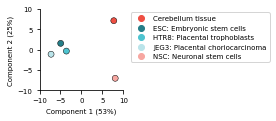

In [12]:
from sklearn.decomposition import PCA

pca_data = sig_prox.loc[~sig_prox['group'].isna(), ['label','tissue_desc','deltaRelUsage_mean']].pivot(index = 'label', columns = 'tissue_desc', values = 'deltaRelUsage_mean').fillna(0).T
print(pca_data.shape)

pca = PCA(n_components=2).fit(pca_data.to_numpy())
pca_data_transformed = pd.DataFrame(data = pca.transform(pca_data.to_numpy()), index = pca_data.index.values, columns = ['component1','component2']).reset_index()

fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

sns.scatterplot(data = pca_data_transformed, x = 'component1', y = 'component2',
                hue = 'index', palette = pca_palette, edgecolor = 'black',
                ax = ax)

ax.set_xlabel(f"Component 1 ({pca.explained_variance_ratio_[0]:.0%})")
ax.set_xlim(-10,10)
ax.xaxis.set_major_locator(MultipleLocator(5))

ax.set_ylabel(f"Component 2 ({pca.explained_variance_ratio_[1]:.0%})")
ax.set_ylim(-10,10)
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'dapa.pca.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Visualizing trends in tissue-specific pair distances and site strength

In [13]:
palette = {
    'brain-specific'    : '#F5918A',
    'brain-weak'        : '#808080',
    'brain-mixed'       : '#808080',
    'placenta-mixed'    : '#808080',
    'placenta-weak'     : '#C79DC8',
    'placenta-specific' : '#4EC4D0',
}

In [14]:
def statistical_tests(data, xvar, yvar, groups):
    
    print("\nSummary data:")
    print(data.groupby(xvar)[yvar].describe().loc[groups])
    
    print("\nGroup medians:")
    print(data.groupby(xvar)[yvar].agg('median').loc[groups])
    
    print("\nKruskal-Wallis:")
    print("\tGroup sizes =", [len(data.loc[data[xvar] == g, yvar].tolist()) for g in groups])
    print("\tP-value =", st.kruskal(*[data.loc[data[xvar] == g, yvar].tolist() for g in groups])[1])

    print("\nWilcoxon rank-sum, brain vs placenta, including mixed:")
    print("\tGroup sizes =", [len(data.loc[data[xvar].str.contains('brain'), yvar]), len(data.loc[data[xvar].str.contains('placenta'), yvar])])
    print("\tP-value =", st.ranksums(data.loc[data[xvar].str.contains('brain'), yvar], data.loc[data[xvar].str.contains('placenta'), yvar])[1])
    
    print("\nWilcoxon rank-sum, brain-specific vs placenta-specific:")
    print("\tGroup sizes =", [len(data.loc[data[xvar] == 'brain-specific', yvar]), len(data.loc[data[xvar] == 'placenta-specific', yvar])])
    print("\tP-value =", st.ranksums(data.loc[data[xvar] == 'brain-specific', yvar], data.loc[data[xvar] == 'placenta-specific', yvar])[1])
    
    return


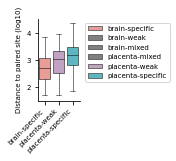

Corresponding statistics:

Summary data:
                    count      mean       std      min       25%       50%  \
group                                                                        
brain-specific      226.0  2.687196  0.503072  1.69897  2.283301  2.719324   
placenta-weak       405.0  2.922985  0.547076  1.69897  2.502427  3.042969   
placenta-specific  1004.0  3.092210  0.495178  1.69897  2.810904  3.179408   

                        75%       max  
group                                  
brain-specific     3.060601  3.830525  
placenta-weak      3.333850  3.952066  
placenta-specific  3.456935  4.359968  

Group medians:
group
brain-specific       2.719324
placenta-weak        3.042969
placenta-specific    3.179408
Name: pair_distance_log10, dtype: float64

Kruskal-Wallis:
	Group sizes = [226, 405, 1004]
	P-value = 1.605894502655098e-26

Wilcoxon rank-sum, brain vs placenta, including mixed:
	Group sizes = [816, 2481]
	P-value = 7.36346481529518e-35

Wilcoxon rank-su

In [18]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

desc = 'proximal'
yvar = 'pair_distance_log10'
xvar = 'group'
xord = ['brain-specific','placenta-weak','placenta-specific']
data = plot_data.loc[~plot_data[xvar].isna()]

sns.boxplot(data = data, x = xvar, y = yvar, order = xord,
            hue = xvar, dodge = False, palette = palette,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, showfliers = False, 
            ax = ax)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("Distance to paired site (log10)")
ax.set_ylim(1.5,4.5)
ax.yaxis.set_major_locator(MultipleLocator(1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, f'dapa.{desc}.{xvar}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding statistics:")
statistical_tests(data, xvar, yvar, ['brain-specific','placenta-weak','placenta-specific'])


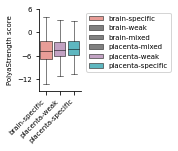

Corresponding statistics:

Summary data:
                    count      mean       std        min       25%       50%  \
group                                                                          
brain-specific      226.0 -4.467506  3.357138 -13.236989 -6.848254 -4.733110   
placenta-weak       405.0 -4.063708  2.936278 -11.115202 -6.146468 -4.436327   
placenta-specific  1004.0 -4.030255  2.763459 -15.746687 -5.907489 -4.302259   

                        75%       max  
group                                  
brain-specific    -2.125334  4.020385  
placenta-weak     -2.397695  6.202134  
placenta-specific -2.328907  7.908082  

Group medians:
group
brain-specific      -4.733110
placenta-weak       -4.436327
placenta-specific   -4.302259
Name: strength, dtype: float64

Kruskal-Wallis:
	Group sizes = [226, 405, 1004]
	P-value = 0.19895681734949622

Wilcoxon rank-sum, brain vs placenta, including mixed:
	Group sizes = [816, 2481]
	P-value = 0.6071420039754791

Wilcoxon rank-sum, br

In [16]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

desc = 'proximal'
yvar = 'strength'
xvar = 'group'
xord = ['brain-specific','placenta-weak','placenta-specific']
data = plot_data.loc[~plot_data[xvar].isna()]

sns.boxplot(data = data, x = xvar, y = yvar, order = xord,
            hue = xvar, dodge = False, palette = palette,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, showfliers = False, 
            ax = ax)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel("PolyaStrength score")
ax.set_ylim(-15,6)
ax.yaxis.set_major_locator(MultipleLocator(6))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, f'dapa.{desc}.{xvar}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding statistics:")
statistical_tests(data, xvar, yvar, ['brain-specific','placenta-weak','placenta-specific'])


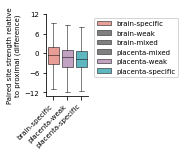

Corresponding statistics:

Summary data:
                    count      mean       std        min       25%       50%  \
group                                                                          
brain-specific      226.0 -0.863693  4.398779 -14.685463 -3.377308 -0.439358   
placenta-weak       405.0 -1.477901  4.272523 -14.368120 -4.153372 -1.043666   
placenta-specific  1004.0 -1.722773  3.844470 -14.439268 -4.285019 -1.620239   

                        75%        max  
group                                   
brain-specific     2.032174   9.353867  
placenta-weak      1.111681  10.691276  
placenta-specific  0.765889  14.129619  

Group medians:
group
brain-specific      -0.439358
placenta-weak       -1.043666
placenta-specific   -1.620239
Name: strength_difference, dtype: float64

Kruskal-Wallis:
	Group sizes = [226, 405, 1004]
	P-value = 0.003455286361897114

Wilcoxon rank-sum, brain vs placenta, including mixed:
	Group sizes = [816, 2481]
	P-value = 0.0006912587022557967

W

In [17]:
fig,ax = plt.subplots(1,1, figsize = (0.75,1.5))

desc = 'proximal'
yvar = 'strength_difference'
xvar = 'group'
xord = ['brain-specific','placenta-weak','placenta-specific']
data = plot_data.loc[~plot_data[xvar].isna()]

sns.boxplot(data = data, x = xvar, y = yvar, order = xord,
            hue = xvar, dodge = False, palette = palette,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black', 'markersize' : 1}, showfliers = False, 
            ax = ax)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', va = 'top')

ax.set_ylabel(f"Paired site strength relative\nto {desc} (difference)")
ax.set_ylim(-13,12)
ax.yaxis.set_major_locator(MultipleLocator(6))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(bbox_to_anchor = (1.05,1))

plt.savefig(os.path.join(OUTDIR, f'dapa.{desc}.{xvar}.{yvar}.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding statistics:")
statistical_tests(data, xvar, yvar, ['brain-specific','placenta-weak','placenta-specific'])
